In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Perform combined over and undersampling on the diabetes dataset (use SMOTEENN). Explain how combined sampling works.
- Oversampling, undersampling for combined sampling is used in situations where Dataset lables are imbalanced. Random oversampling involves randomly duplicating examples in the minority class, whereas random undersampling involves randomly deleting examples from the majority class so both are balanced.
- When both oversampling and undersampling is done on the dataset it is called as combined sampling.
- SMOTE-ENN method combines the SMOTE ability to generate synthetic examples for minority class and ENN ability to delete some observations from both classes that are identified as having different class between the observation’s class and its K-nearest neighbor majority class.


In [3]:
#Load diabetes dataset
diabetes_df = pd.read_csv("../week_13/diabetes.csv")
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
#This shows imbalance in dataset
diabetes_df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
#Feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X2 = diabetes_df.drop(["Outcome"],axis=1)
y2 = diabetes_df["Outcome"]

model = LogisticRegression()

#Initializing RFE model
rfe = RFE(model, n_features_to_select=5)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X2,y2)  

#Fitting the data to model
model.fit(X_rfe,y2)
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False False  True  True  True]
[1 1 2 3 4 1 1 1]


In [6]:
#Get the feature names where features supports
rfe_features = X2.columns[np.where(rfe.support_ == True)[0]]
print(rfe_features)

Index(['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')


In [7]:
#X = diabetes_df.drop('Outcome',axis=1)
#X = diabetes_df[rfe_features]
X = diabetes_df[['Glucose','BMI']]
y = diabetes_df['Outcome']

In [8]:
#Split into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=42,stratify=y)

In [9]:
#Perform standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaler = sc.fit_transform(X_train)
X_test_scaler = sc.fit_transform(X_test)

In [10]:
#SMOTE-ENN
from collections import Counter
from imblearn.combine import SMOTEENN 
from imblearn.under_sampling import EditedNearestNeighbours

print('Original dataset shape %s' % Counter(y_train))
#sme = SMOTEENN(random_state=42)
sme = SMOTEENN(random_state=42,enn=EditedNearestNeighbours(sampling_strategy='all'))
X_res, y_res = sme.fit_resample(X_train_scaler, y_train)
print('Resampled dataset shape %s' % Counter(y_res))


Original dataset shape Counter({0: 375, 1: 201})
Resampled dataset shape Counter({1: 192, 0: 182})


In [11]:
#Perfomr logistic regression on combined sampled data
from sklearn.linear_model import LogisticRegression
#Logistic regression
lregmodel = LogisticRegression(random_state=42)
lregmodel.fit(X_res,y_res)


LogisticRegression(random_state=42)

In [12]:
#Calculate accuracy
from sklearn.metrics import balanced_accuracy_score
y_pred = lregmodel.predict(X_test_scaler)
balanced_accuracy_score(y_test,y_pred)

0.7147462686567164

## 2. Comment on the performance of combined sampling vs the other approaches we have used for the diabetes dataset.

- Multiple logistic regression
    - Recall - 0.84
    - Score - 0.72
    
- Decision Tree
    - Recall - 0.85
    - Score - 0.78
    
- KNN
    - Recall - 0.87
    - Score - 0.75
    
- SMOTE 
    - Recall - 0.74
    - Score - 0.74
    
* Out of all above mentioned models I got low recall value using SMOTE-ENN
    - SMOTE-ENN
       - Using Glucose','BMI' features 
           - Recall - 0.73
           - Score - 0.72

        - Using features given by feature selection
            - Recall - 0.70
            - Score - 0.73


In [13]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
confusion_matrix(y_test,y_pred)

array([[91, 34],
       [20, 47]], dtype=int64)

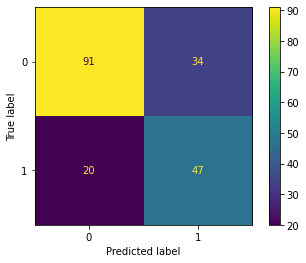

In [14]:
#PLot confusion matrix
plot_confusion_matrix(lregmodel,X_test_scaler,y_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       125
           1       0.58      0.70      0.64        67

    accuracy                           0.72       192
   macro avg       0.70      0.71      0.70       192
weighted avg       0.74      0.72      0.72       192



In [16]:
#Balanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.73      0.70      0.77      0.71      0.51       125
          1       0.58      0.70      0.73      0.64      0.71      0.51        67

avg / total       0.74      0.72      0.71      0.72      0.71      0.51       192



## 3. What is outlier detection? Why is it useful? What methods can you use for outlier detection?
* Outliers are extreme values that deviate from other observations in data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an outlier is an observation that diverges from an overall pattern on a sample.
* These can be questions to identify outliers 
    - Which and how many features to consider for outlier detection? (univariate / multivariate)
    - Distribution(s) of values for selected features? (parametric / non-parametric)
* It is useful to avoid machine learning model getting affected by extreme values in data. Outliers in input data can skew and mislead the training process of machine learning algorithms resulting in longer training times, less accurate models and ultimately poorer results.


* There are four Outlier Detection techniques in general.

    1.Numeric Outlier  - Numeric Outlier is the simplest, nonparametric outlier detection technique in a one-dimensional feature space.   
    - Outlier detection values beyond 1st and 3rd inter quartile range. 
    - Box whisker plot can be used to detect outliers
    2.Z-Score
    - Z-score technique assumes a Gaussian distribution of the data. The outliers are the data points that are in the tails of the distribution and therefore far from the mean.
    3.DBSCAN
    - This Outlier Detection technique is based on the DBSCAN clustering method. DBSCAN is a nonparametric, density-based outlier detection method in a one or multi-dimensional feature space. Here, all data points are defined either as Core Points, Border Points or Noise Points.
    4.Isolation Forest
    - This nonparametric method is ideal for large datasets in a one or multi-dimensional feature space. The isolation number is of paramount importance in this Outlier Detection technique. The isolation number is the number of splits needed to isolate a data point. 
        
        
* Some of the most popular methods for outlier detection are:
    - Z-Score or Extreme Value Analysis (parametric)
    - Probabilistic and Statistical Modeling (parametric)
    - Linear Regression Models (PCA, LMS)
    - Proximity Based Models (non-parametric)
    - Information Theory Models
    - High Dimensional Outlier Detection Methods (high dimensional sparse data)

## 4. Perform a linear SVM to predict credit approval (last column) using this dataset: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29 . Make sure you look at the accompanying document that describes the data in the dat file. You will need to either convert this data to another file type or import the dat file to python. 


In [92]:
#Load Australian credit approval dataset in pandas dataframe from .dat file
credit_df = pd.read_table("australian.dat", sep=" ",header=None)
columns_list = ['A1', 'A2', 'A3', 'A4','A5', 'A6', 'A7', 'A8','A9', 'A10', 'A11', 'A12','A13', 'A14', 'A15']
credit_df.columns = columns_list 
credit_df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


In [18]:
#Checking for null values, there are no null values
credit_df.isnull().sum()

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
dtype: int64

<AxesSubplot:>

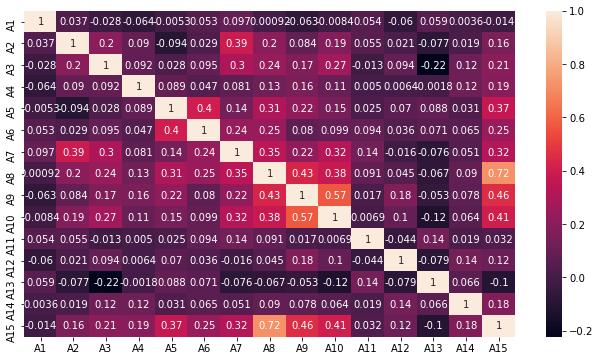

In [19]:
#Check heatmap
plt.figure(figsize=[11,6])
sns.heatmap(credit_df.corr(),annot=True)

## Removing outliers

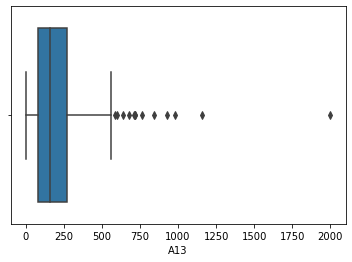

In [20]:
#Found outliers in following features
#A2 outliers >=70
#A3 outliers >=25
#A6 outlier <= 2 and >=7
#A7 outliers >=15
#A10 outliers >=20
#A13 outliers >=1000
#A14 outlier >=20000

sns.boxplot(data=credit_df,x='A13')
credit_df = credit_df.query("A13<=1000")


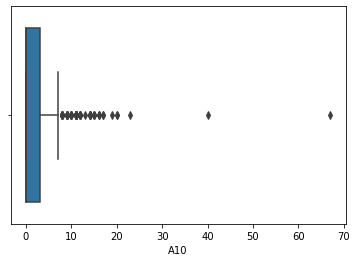

In [21]:
sns.boxplot(data=credit_df,x='A10')
credit_df = credit_df.query("A10<=20")

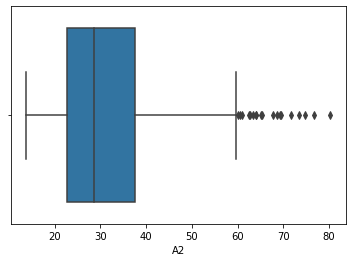

In [22]:
sns.boxplot(data=credit_df,x='A2')
credit_df = credit_df.query("A2<=70")

In [53]:
#Feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X2 = credit_df.drop(["A15"],axis=1)
y2 = credit_df["A15"]

model = LogisticRegression()
#model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, n_features_to_select=6)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X2,y2)  

#Fitting the data to model
model.fit(X_rfe,y2)
print(rfe.support_)
print(rfe.ranking_)


[False False False  True  True False False  True  True False  True  True
 False False]
[5 8 6 1 1 4 3 1 1 2 1 1 7 9]


In [54]:
#Get the feature names where feature supports
rfe_features = X2.columns[np.where(rfe.support_ == True)[0]]
print(rfe_features)


Index(['A4', 'A5', 'A8', 'A9', 'A11', 'A12'], dtype='object')


In [55]:
#Set X and y
X = credit_df[rfe_features]
#X = credit_df.drop(["A15"],axis=1)
y = credit_df['A15']

In [56]:
#There is a imbalance in dataset
credit_df['A15'].value_counts()

0    379
1    301
Name: A15, dtype: int64

In [79]:
#Split into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=42,stratify=y)


In [80]:
#Perform standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaler = sc.fit_transform(X_train)
X_test_scaler = sc.fit_transform(X_test)

In [81]:
from sklearn.svm import SVC
#classifier = SVC(kernel='linear')        
classifier = SVC(C=10, gamma=0.01, kernel='linear')
classifier.fit(X_train_scaler,y_train)
y_pred = classifier.predict(X_test_scaler)

## 5. How did the SVM model perform? Use a classification report. 
- with parameters, C=10, gamma=0.01, kernel='linear'
- using feature selection or using all features except target gave same scores
    - Precision       Recall       F1 Score  Accuracy
    -    0.95          0.83          0.89      0.88
 

* Looking at confusion matrix, model has low false negatives. It can be used to deny credit approval, but not approve credit.

In [82]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
confusion_matrix(y_test,y_pred)

array([[79, 16],
       [ 4, 71]], dtype=int64)

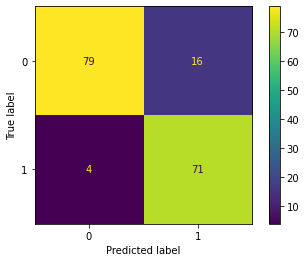

In [83]:
#Plot confusion matrix
plot_confusion_matrix(classifier,X_test_scaler,y_test)

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89        95
           1       0.82      0.95      0.88        75

    accuracy                           0.88       170
   macro avg       0.88      0.89      0.88       170
weighted avg       0.89      0.88      0.88       170



## 6. What kinds of jobs in data are you most interested in? Do some research on what is out there. Write about your thoughts in under 400 words. 
* Google, indeed job search shows there are different data jobs posted like
    - Data Analyst
    - Data Scientist
    - Data Engineer
    - Machine Engineer
    - Data Architect
    - Database Administrator
    - Database developer

* Responsibilities mentioned in the job listings included: Work with functional business partners to fully understand their data and enable insight discovery and to support data driven decisions. Use data science and machine learning techniques to help drive deep data analysis and uncover insights that will enable the business to make strong and strategic decisions.



* My thoughts and interest
    - Industry intertest - Healthcare, consumer product, supply chain, logistics
    - When searching, I was particularly looking for data science jobs in Health care. I saw some job postings by BJC, Mercy, Centene, Data Analyst/Data Engineer jobs in Washu. I am passionate to learn and enable Healthcare sector using technology.  
    - I am intrigued by consumer product, supply chain and transportation/logistic industry and mechanics of how they work. At the same time, I think there are some great opportunities to improve efficiency using data science in these industries.e.g seasonality, buying patterns based on events e.g storms, snow etc. I found Data Sciene/Data Analyst job postings by Nestle, Emerson, Kraft
    - I have worked on SQL - DDL, DML , select queries, creating stored procedures, triggers in my previous work experience. Writing the business layer code(using C# and .Net) with input from front end layer and transform to database layer(SQL Server). I have also worked on Crystal reports to generate and present reports by querying the database. 
    - Last year I volunteered at UMSL - Center for Behavioral Health(CBH) to help with thier database and crystal report. I was thrilled to learn I had that drive even after long work gap. It was exciting for me to go above and beyond my responsibility as a volunteer to resolve thier long pending issues with crystal reports.
    - I am passionate about working with data and understand relationship between entities, generate reports/visualizations and find patterns. 
    - Data Science field is very interesting. I love learning, working and exploring Python and its different libraries like pandas,numpy, matplotlib and seaborn,sci-kit learn etc. Working on exploratory data analysis and ETL project was my strength. Machine learning is challenging and I feel I need more time to understand the different models,learn when and what situations to apply them and how to measure the performance of the models. I am motivated to learn more about it.
    - I am also motivated to learn Tableau as one of the visualization tool so I could be more versatile to work on data science/data analyst roles.


* It is also important for me to look for companies which  
    - are friendly to support different personalities and working styles 
    - are mom friendly
    - has flexible work policies
    - allows working remotely